In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from z3 import *
from IPython.display import Markdown, display,HTML,Image
from itertools import combinations,product
from matplotlib.patches import Rectangle
from ortools.linear_solver import pywraplp
import pulp

### Puzzle as published 
https://www.janestreet.com/puzzles/almost-magic-index/

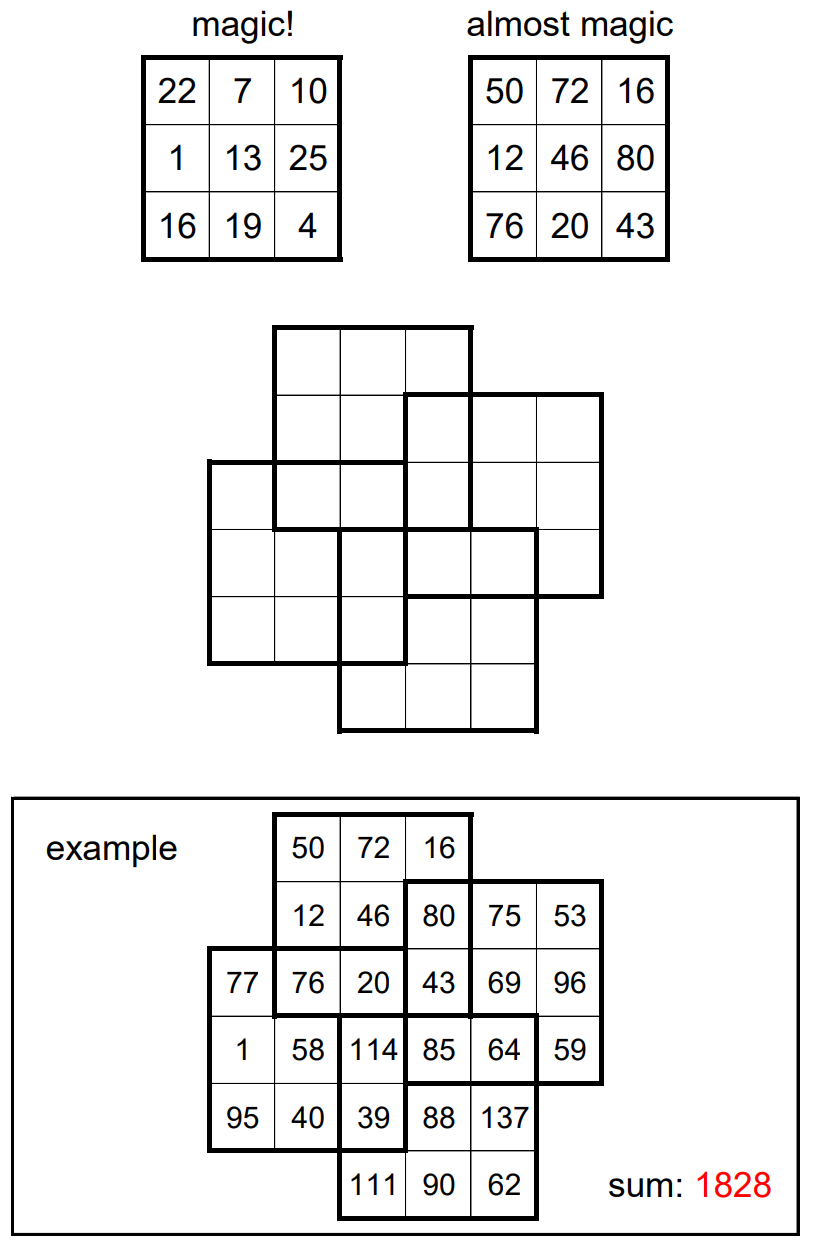

In [2]:
url='https://www.janestreet.com/puzzles/almost-magic-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/almost_magic.png',width=250))
img = "<img src=\"/puzzles/almost_magic.png\"/>"
display(HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[0]).replace(img,"")))

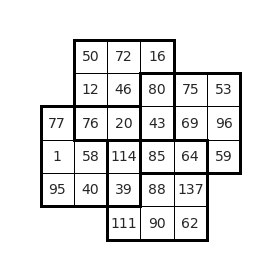

**Check Grids**

[138, 138, 139, 138, 138, 139, 139, 138]
[208, 208, 208, 208, 208, 208, 208, 207]
[173, 174, 173, 173, 173, 174, 174, 173]
[264, 263, 263, 263, 264, 263, 264, 263]


In [3]:
# print and check the grids
def print_grid(res):
    x =[-1,-1,-1,-1,-1,-1,-1,-1,
        -1,-1, 0, 1, 2,-1,-1,-1,
        -1,-1, 3, 4, 5, 6, 7,-1,
        -1, 8, 9,10,11,12,13,-1,
        -1,14,15,16,17,18,19,-1,
        -1,20,21,22,23,24,-1,-1,
        -1,-1,-1,25,26,27,-1,-1,
        -1,-1,-1,-1,-1,-1,-1,-1]

    annot =np.array([str(res[i]) if i>=0 else "" for i in x]).reshape(8,8)

    fig,ax = plt.subplots(1,1,figsize=(4,4))
    ax = sns.heatmap(np.zeros((8,8)),annot =annot,fmt='',cbar=False,cmap='Greys',linecolor='w',linewidth=2,annot_kws={"fontsize":14})
    for i,j in product(range(8),repeat=2):
        if annot[i,j]!="":
            ax.add_patch(Rectangle((j,i), 1, 1, fill=False, edgecolor='k', lw=1))
    ax.add_patch(Rectangle((1,3), 3, 3, fill=False, edgecolor='k', lw=3))
    ax.add_patch(Rectangle((2,1), 3, 3, fill=False, edgecolor='k', lw=3))
    ax.add_patch(Rectangle((4,2), 3, 3, fill=False, edgecolor='k', lw=3))
    ax.add_patch(Rectangle((3,4), 3, 3, fill=False, edgecolor='k', lw=3))
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    display(Markdown(("**Check Grids**")))
    sq1 = [[0,1,2],[3,4,5],[9,10,11]]
    sq2 = [[5,6,7],[11,12,13],[17,18,19]]
    sq3 = [[8,9,10],[14,15,16],[20,21,22]]
    sq4 = [[16,17,18],[22,23,24],[25,26,27]]

    show = np.vectorize(lambda x:int(res[x]))

    for i in [sq1,sq2,sq3,sq4]:
        print(str(list(np.sum(show(i),axis=0))+list(np.sum(show(i),axis=1))+[np.sum(np.trace(show(i)))]+[np.sum(np.trace(np.rot90(show(i))))]))
        
print_grid([50, 72, 16, 12, 46, 80, 75, 53, 77, 76, 20, 43, 69, 96, 1, 58, 114, 85, 64, 59, 95, 40, 39, 88, 137, 111, 90, 62])

In [4]:
# Almost magic square constraints
def sq_const(X,sq,g):
    grid = np.vectorize(lambda x:X[x])
    magic = grid(sq)
    tri = list(np.sum(magic,axis=0))+\
          list(np.sum(magic,axis=1))+\
          list([np.trace(magic)])+\
          list([np.trace(np.rot90(magic))])    
    for a,b in combinations(tri,2):
        g.add(a-b <= 1)
        g.add(a-b >=-1)
    return g

# Solver. Key is to maintain as a LIA problem and break symmetry so it 
# doesn't get stuck between similar correct solutions
# z3 is very quick on this. Tried CBC in pulp and 
# SCIP in Or-Tools which took longer. Is Gurobi any faster I wonder?
# iterating using smt or other tactics also works

def solve(opt=True,tac="smt",lim=1111,timeout=10000):
    #set up the solver 
    g = Goal()
    X = IntVector("x",28) 
                
    # limit the values and ensure distinct
    g.add([e>0 for e in X])
    g.add(Distinct([e for e in X]))
       
    # define the squares
    sq1 = [[0,1,2],[3,4,5],[9,10,11]]
    sq2 = [[5,6,7],[11,12,13],[17,18,19]]
    sq3 = [[8,9,10],[14,15,16],[20,21,22]]
    sq4 = [[16,17,18],[22,23,24],[25,26,27]]
    
    g = sq_const(X,sq1,g)
    g = sq_const(X,sq2,g)
    g = sq_const(X,sq3,g)
    g = sq_const(X,sq4,g)
    
    # break symmetry of the solutions (this took some time to it this quick.. I solved and submitted
    # using the simplest version with he first cell being max of the 4 equivalents)
    #g.add(X[0] > X[7])
    #g.add(X[0] > X[27])
    #g.add(X[0] > X[20])
    
    g.add(X[10] > X[11])
    g.add(X[11] > X[16])
    g.add(X[16] > X[17])

    g.add(X[0] > X[7])
    g.add(X[7] > X[27])
    g.add(X[27]> X[20]) 
          
    #p = Probe("is-lia")
    #display(Markdown("Check if lia : **{}**".format(bool(p(g)))))
    
    x=[]
    
    if opt:    
        s = Optimize()
        s.add(g) 
        s.minimize(Sum(X))
        if s.check() == sat:
            m = s.model()
            evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
            x = evalu(X)    
        else:
            print("Fail")
    
    else:
        start=time.time()
        s= Tactic(tac).solver()
        s.add(g)
        s.set("timeout", timeout)
        s.add(Sum(X) < lim)  
        while s.check() == sat:
            m = s.model()
            evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
            x = evalu(X)
            display(Markdown(("Found: **{:.0f}** after {:.2f} seconds\n".format(sum(x),time.time()-start))))
            s.add(Sum(X) < int(np.sum(x)))  
    return(x)

Minimum Total: **470** took 9.59 seconds


26, 2, 34, 29, 21, 13, 4, 18, 24, 7, 39, 16, 12, 6, 37, 23, 9, 5, 19, 10, 8, 40, 22, 11, 1, 3, 17, 14

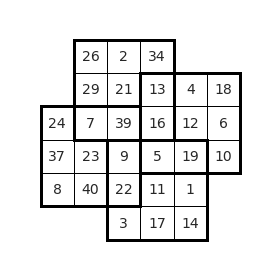

**Check Grids**

[62, 62, 63, 62, 63, 62, 63, 62]
[34, 35, 34, 35, 34, 34, 35, 35]
[69, 70, 70, 70, 69, 70, 69, 70]
[34, 33, 34, 33, 34, 34, 34, 33]


In [5]:
start= time.time()
res =solve()
display(Markdown(("Minimum Total: **{:.0f}** took {:.2f} seconds\n".format(sum(res),time.time()-start))))
display(Markdown((", ".join([str(int(i)) for i in res]))))
print_grid(res)

Found: **884** after 0.70 seconds


Found: **760** after 1.29 seconds


Found: **716** after 2.53 seconds


Found: **695** after 4.09 seconds


Found: **606** after 6.08 seconds


Found: **593** after 10.45 seconds


Found: **584** after 17.09 seconds


Found: **579** after 19.37 seconds


Found: **574** after 21.09 seconds


Found: **547** after 27.66 seconds


Found: **546** after 37.24 seconds


Found: **540** after 41.48 seconds


Found: **539** after 43.07 seconds


Found: **531** after 49.20 seconds


Found: **498** after 53.56 seconds


Found: **491** after 57.14 seconds


Found: **484** after 62.82 seconds


Found: **470** after 66.66 seconds


Minimum Total: **470** took 76.73 seconds


26, 2, 34, 29, 21, 13, 4, 18, 24, 7, 39, 16, 12, 6, 37, 23, 9, 5, 19, 10, 8, 40, 22, 11, 1, 3, 17, 14

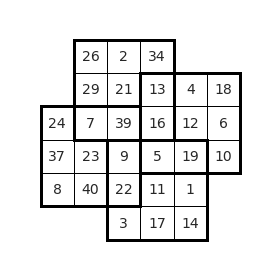

**Check Grids**

[62, 62, 63, 62, 63, 62, 63, 62]
[34, 35, 34, 35, 34, 34, 35, 35]
[69, 70, 70, 70, 69, 70, 69, 70]
[34, 33, 34, 33, 34, 34, 34, 33]


In [6]:
start= time.time()
res =solve(opt=False,tac="qflia",lim=1111)
display(Markdown(("Minimum Total: **{:.0f}** took {:.2f} seconds\n".format(sum(res),time.time()-start))))
display(Markdown((", ".join([str(int(i)) for i in res]))))
print_grid(res)

Found: **641** after 0.53 seconds


Found: **604** after 0.84 seconds


Found: **603** after 1.22 seconds


Found: **601** after 1.72 seconds


Found: **576** after 2.16 seconds


Found: **575** after 2.72 seconds


Found: **546** after 3.38 seconds


Found: **543** after 4.93 seconds


Found: **520** after 7.38 seconds


Found: **519** after 9.44 seconds


Found: **498** after 12.49 seconds


Found: **497** after 14.05 seconds


Found: **496** after 16.73 seconds


Found: **495** after 20.43 seconds


Found: **494** after 22.72 seconds


Found: **491** after 27.41 seconds


Found: **480** after 32.29 seconds


Found: **470** after 38.67 seconds


Minimum Total: **470** took 46.49 seconds


26, 2, 34, 29, 21, 13, 4, 18, 24, 7, 39, 16, 12, 6, 37, 23, 9, 5, 19, 10, 8, 40, 22, 11, 1, 3, 17, 14

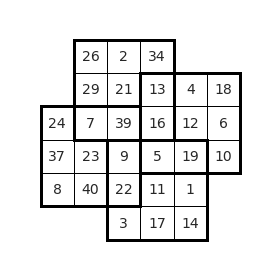

**Check Grids**

[62, 62, 63, 62, 63, 62, 63, 62]
[34, 35, 34, 35, 34, 34, 35, 35]
[69, 70, 70, 70, 69, 70, 69, 70]
[34, 33, 34, 33, 34, 34, 34, 33]


In [7]:
start= time.time()
res =solve(opt=False,tac="smt",lim=1111)
display(Markdown(("Minimum Total: **{:.0f}** took {:.2f} seconds\n".format(sum(res),time.time()-start))))
display(Markdown((", ".join([str(int(i)) for i in res]))))
print_grid(res)

### Soln as published 
https://www.janestreet.com/puzzles/almost-magic-solution/

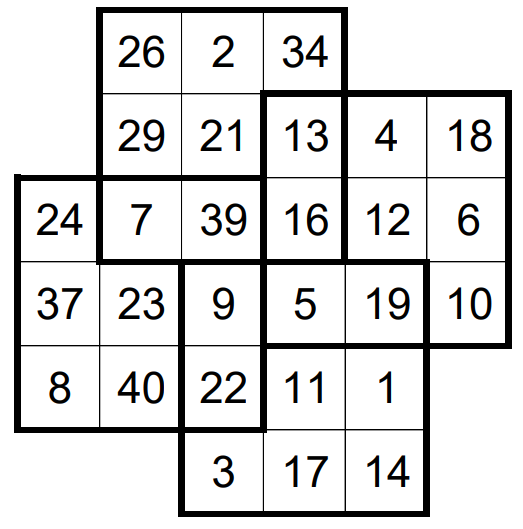

In [6]:
# Pull in the puzzle solution and grids from the solution page
url='https://www.janestreet.com/puzzles/almost-magic-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Soln as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/almost_magic_solution.png',width=300))
display(HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1])))

Minimum Total: **470** took 48.47 seconds


26,2,34,29,21,13,4,18,24,7,39,16,12,6,37,23,9,5,19,10,8,40,22,11,1,3,17,14

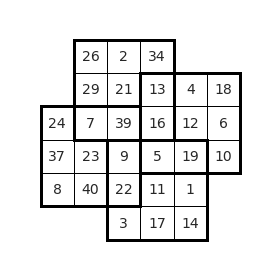

**Check Grids**

[62, 62, 63, 62, 63, 62, 63, 62]
[34, 35, 34, 35, 34, 34, 35, 35]
[69, 70, 70, 70, 69, 70, 69, 70]
[34, 33, 34, 33, 34, 34, 34, 33]


In [9]:
def sq_const_lp(X,sq,model):
    grid = np.vectorize(lambda s:X[s])
    magic = grid(sq)
    tri = [sum(magic[:,0]),
           sum(magic[:,1]),
           sum(magic[:,2]),
           sum(magic[0,:]),
           sum(magic[1,:]),
           sum(magic[2,:]),
           magic[0,0]+magic[1,1]+magic[2,2],
           magic[0,2]+magic[1,1]+magic[2,0]       
          ]
    for a,b in combinations(tri,2):
        model.Add(a-b <= 1)
        model.Add(a-b >=-1)   
    return model    

def solve_lp():
    #define problem and solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    slots = range(28)
    max_v = 200

    # set up variables
    X = {}
    for s in slots:
            X[(s)] = solver.IntVar(1,max_v,"x{}".format(s))

    #objective        
    solver.Minimize(sum([X[(s)] for s in slots]))

    # values unique. Bool if value a > value b
    Y = {}
    for a,b in combinations(slots,2):
        Y[(a,b)] = solver.BoolVar("y{}{}".format(a,b))

    # Y = 0  => b >= a+1
    # Y = 1 => a >= b+1
    for a,b in combinations(slots,2):
            solver.Add(X[a] >= X[b] +    Y[(a,b)]  - max_v *(1-Y[(a,b)]))  
            solver.Add(X[b] >= X[a] + (1-Y[(a,b)]) - max_v * Y[(a,b)] )

    # define the squares
    sq0 = [[0,1,2],[3,4,5],[6,7,8]]
    sq1 = [[0,1,2],[3,4,5],[9,10,11]]
    sq2 = [[5,6,7],[11,12,13],[17,18,19]]
    sq3 = [[8,9,10],[14,15,16],[20,21,22]]
    sq4 = [[16,17,18],[22,23,24],[25,26,27]]

    solver = sq_const_lp(X,sq1,solver)
    solver = sq_const_lp(X,sq2,solver)
    solver = sq_const_lp(X,sq3,solver)
    solver = sq_const_lp(X,sq4,solver)

    #break symmetry
    solver.Add(X[10]>=X[11])
    solver.Add(X[11]>=X[16])
    solver.Add(X[16]>=X[17])

    solver.Add(X[0] >=X[7])
    solver.Add(X[7]>=X[27])
    solver.Add(X[27]>=X[20])

    start = time.time()
    status = solver.Solve()
    res =[int(e.solution_value()) for _,e in X.items()]
    display(Markdown(("Minimum Total: **{:.0f}** took {:.2f} seconds\n".format(sum(res),time.time()-start))))
    display(Markdown((",".join([str(int(i)) for i in res]))))
    print_grid(res)
                      
solve_lp()

In [10]:
def sq_const_pulp(X,sq,values,model):
    grid = np.vectorize(lambda x:pulp.lpSum([X[x]]))
    magic = grid(sq)
    tri = [pulp.lpSum(magic[:,0]),
          pulp.lpSum(magic[:,1]),
          pulp.lpSum(magic[:,2]),
          pulp.lpSum(magic[0,:]),
          pulp.lpSum(magic[1,:]),
          pulp.lpSum(magic[2,:]),
          pulp.lpSum(np.trace(magic)),
          pulp.lpSum(np.trace(np.rot90(magic)))       
          ]
    for a,b in combinations(tri,2):
        model += a-b <= 1
        model += a-b >=-1    
    return model     
       
def solve_pulp():
    slots = range(28)
    values = 100

    #set up the solver and variables.
    model=pulp.LpProblem('magic',pulp.LpMinimize)
        
    #cell values
    X = pulp.LpVariable.dicts("N",[s for s in slots],lowBound=1,upBound=values,cat='Integer')
    
    # objective
    model += pulp.lpSum([X[(s)] for s in slots]) 
        
    #each value unique
    Y = pulp.LpVariable.dicts("Y",[(a,b) for a in slots for b in slots],cat='Binary')
 
    for a,b in combinations(slots,2):
        model += X[a] >= X[b] +    Y[(a,b)]  - values * (1-Y[(a,b)])
        model += X[b] >= X[a] + (1-Y[(a,b)]) - values * Y[(a,b)] 
      
    # define the squares
    sq1 = [[0,1,2],[3,4,5],[9,10,11]]
    sq2 = [[5,6,7],[11,12,13],[17,18,19]]
    sq3 = [[8,9,10],[14,15,16],[20,21,22]]
    sq4 = [[16,17,18],[22,23,24],[25,26,27]]
    
    model = sq_const_pulp(X,sq1,values,model)
    model = sq_const_pulp(X,sq2,values,model)
    model = sq_const_pulp(X,sq3,values,model)
    model = sq_const_pulp(X,sq4,values,model)
    
    #break symmetry
    model +=(X[10]>=X[11])
    model +=(X[11]>=X[16])
    model +=(X[16]>=X[17])

    model +=(X[0] >=X[7])
    model +=(X[7]>=X[27])
    model +=(X[27]>=X[20])
    
    model.solve(pulp.PULP_CBC_CMD(mip=True))

    x = np.array([int(v.varValue) for k,v in X.items()],dtype=int)
    return x

Minimum Total: **470** took 73.53 seconds


26,2,34,29,21,13,4,18,24,7,39,16,12,6,37,23,9,5,19,10,8,40,22,11,1,3,17,14

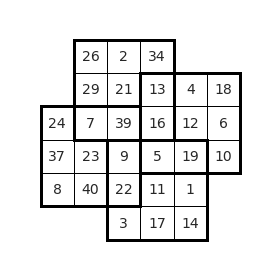

**Check Grids**

[62, 62, 63, 62, 63, 62, 63, 62]
[34, 35, 34, 35, 34, 34, 35, 35]
[69, 70, 70, 70, 69, 70, 69, 70]
[34, 33, 34, 33, 34, 34, 34, 33]


In [11]:
start = time.time()
res =solve_pulp()
display(Markdown(("Minimum Total: **{:.0f}** took {:.2f} seconds\n".format(sum(res),time.time()-start))))
display(Markdown((",".join([str(i) for i in res]))))
print_grid(res)